# Simpel FFN

In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from data_loader import parse_data

import glob
import pandas as pd
import branca

# Import data

In [2]:
files_train = glob.glob('../data/train/*/vehicle-position-matched-online.csv')
files_test = glob.glob('../data/test/*/vehicle-position-matched-online.csv')
train = parse_data(files_train)
test = parse_data(files_test)

train = train.pivot(index='Time',columns='wayId',values='mean')
test = test.pivot(index='Time',columns='wayId',values='mean')
print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

Train Shape:  (579, 80)
Test Shape:  (386, 80)


In [3]:
print("Train before interpolate: ",train.isnull().sum().sum())
print("Test before interpolate: ",test.isnull().sum().sum())
train = train.interpolate()
test = test.interpolate()
print("Train after interpolate: ",train.isnull().sum().sum())
print("Test after interpolate: ",test.isnull().sum().sum())
train

Train before interpolate:  8882
Test before interpolate:  6018
Train after interpolate:  33
Test after interpolate:  31


wayId,103524893,103524902,108233932,108233935,108233940,115678954,115678957,115678974,161632579,162089321,...,78412355,8122758,87341541,87341562,87397711,87398581,87451616,87502481,87502482,87724803
Time,,,,,,,,,,,,,,,,,,,,,
2018-10-01 06:00:00,NaN,NaN,NaN,NaN,0.823044,-0.254722,-0.932189,-0.051455,0.873731,1.012022,...,-0.028947,-0.043839,1.277996,1.033566,0.871422,0.397707,1.413103,-0.491650,NaN,-0.202543
2018-10-01 06:05:00,NaN,NaN,0.783925,-0.971462,0.944746,-0.017591,-0.993191,0.509339,0.531321,1.282640,...,1.123746,0.177115,1.256389,1.293762,0.934617,0.545871,0.745131,1.021698,0.952116,-0.268002
2018-10-01 06:10:00,1.566722,0.472583,0.639357,-0.672326,1.066448,0.219541,-1.054194,0.618191,0.326449,1.063613,...,1.149372,-1.019227,1.153641,0.497737,1.282365,0.694036,0.834718,0.204299,0.831143,0.289584
2018-10-01 06:15:00,0.794886,0.503940,0.494788,-0.373191,0.704554,-0.827262,-0.931566,-0.175330,1.108416,0.844587,...,1.174997,-0.814720,1.439586,-0.298288,1.303586,0.842200,0.999279,0.381266,1.024048,1.139488
2018-10-01 06:20:00,1.216318,0.283851,1.474642,1.393003,0.713909,-0.213505,-0.808937,0.593548,-0.528563,-0.554232,...,-0.962926,0.120610,0.832682,0.767767,1.324806,0.582230,1.163840,1.802255,1.687810,0.752010
2018-10-01 06:25:00,0.902827,0.489485,1.417570,1.293298,0.723263,0.400251,-0.686309,0.355322,-0.164430,-0.471837,...,-0.513608,-0.920082,0.779768,-0.005077,1.229693,0.419798,0.946739,0.833400,1.475722,0.364532
2018-10-01 06:30:00,0.969725,0.524073,1.360499,1.193593,0.863296,0.256642,-0.563681,0.918289,-0.312447,1.049062,...,-0.709311,-0.032651,1.163380,1.085454,1.247999,0.266483,0.606655,-0.135456,1.263634,0.765660
2018-10-01 06:35:00,1.533648,0.648024,1.057755,0.188076,0.859328,0.193518,-0.270008,0.795264,-0.038629,0.981786,...,-0.203751,-1.083794,1.196809,1.008027,1.302721,1.065179,0.686113,-0.283752,0.994939,1.089126
2018-10-01 06:40:00,1.541918,0.467575,1.710865,1.567997,1.197977,-0.841201,-0.728848,0.359187,0.438153,-0.444766,...,-0.765522,-0.027226,0.937970,0.872134,0.888264,0.600538,0.765571,-0.129327,1.347540,-0.411535


768
80


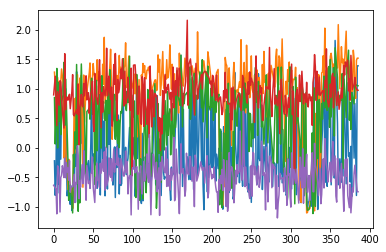

In [4]:
plt.plot(test.values[:,9:14])
print(12*(22-6)*4)
print(train.shape[1])

# Describe the model

In [32]:
#Hyperparameters
num_l1 = 25
num_ways = train.shape[1]

# define network
class Net(nn.Module):
    def __init__(self, num_hidden1, num_output):
        super(Net, self).__init__()
        
        #Dropput and Batchnorm Functions
        self.dropout = nn.Dropout2d(0.2)
        self.batch1 = nn.BatchNorm1d(num_l1)
        
        # Input layer
        #Changed to kaiming normalization
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1,12)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        
        # Hidden layer 1
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(1, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(1), 0))
        
               
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        return x
        #return F.softmax(x, dim=1)

net = Net(num_l1, num_ways)

#Adam Optimizer with L2 weight decay  
optimizer = optim.Adam(net.parameters(),lr = 1e-3, weight_decay = 1e-5)

criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()

In [33]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, 12)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())

torch.Size([45, 1])


# Train and test the model

In [62]:
# setting hyperparameters and gettings epoch sizes
batch_size = 12
num_epochs = 100
num_samples_train = train.shape[0]-1
num_batches_train = num_samples_train - batch_size
num_samples_test = test.shape[0]-1
num_batches_test = num_samples_test - batch_size 

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []
AE = []
get_slice = lambda i, size: range(i - size, i)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(batch_size,num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train.values[slce,:]).float().transpose(0, 1))
        output = net(x_batch).squeeze()
        #print(output)
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(train.values[i+1,:]).float())
        batch_loss = criterion(output, target_batch)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train.values[slce,:]).float().transpose(0, 1))
        
        output = net(x_batch).squeeze()
        preds = output
        
        train_targs += list(train.values[i+1,:])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(batch_size,num_batches_test):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(test.values[slce,:]).float().transpose(0, 1))
        
        output = net(x_batch)
        preds = output
        print(np.squeeze(preds.data.numpy()))
        #print(test.values[i+1,:])
        val_preds += (preds.data.numpy())
        #val_targs += (test.values[i+1,:])
        AE.append(sum(abs(np.squeeze(preds.data.numpy())-test.values[i+1,:]))/batch_size)
    #train_acc_cur = accuracy_score(train_targs, train_preds)
    #valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    #train_acc_cur = sum(train_targs)/len(train_targs)-sum(train_preds)/len(train_preds)
    #valid_acc_cur = sum(val_targs)/len(val_targs)-sum(val_preds)/len(val_preds)
    
    test_mae = sum(AE)/len(AE)
    #print(AE)
    #sum(abs(val_preds - val_targs))/len(val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f, test mae %f" % (
                epoch+1, losses[-1], test_mae))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

[0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223]
[0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35

[0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223]
[0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35

[0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223]
[0.35880223 0.35880223 0.35880223 0.35880223 0.35880223 0.35880223
 0.35880223 0.35880223 0.35880223 0.35

[0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378]
[0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35

[0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378]
[0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35

[0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378]
[0.35902378 0.35902378 0.35902378 0.35902378 0.35902378 0.35902378
 0.35902378 0.35902378 0.35902378 0.35

KeyboardInterrupt: 

In [37]:
x = Variable(torch.from_numpy(test.values).float().transpose(0, 1))
y=net(x)

RuntimeError: size mismatch, m1: [80 x 386], m2: [12 x 25] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:2070

In [106]:
get_slice = lambda i, size: range(i - size, i)

for i in range(12,40):
    slce = get_slice(i, 12)
    print(slce)

range(0, 12)
range(1, 13)
range(2, 14)
range(3, 15)
range(4, 16)
range(5, 17)
range(6, 18)
range(7, 19)
range(8, 20)
range(9, 21)
range(10, 22)
range(11, 23)
range(12, 24)
range(13, 25)
range(14, 26)
range(15, 27)
range(16, 28)
range(17, 29)
range(18, 30)
range(19, 31)
range(20, 32)
range(21, 33)
range(22, 34)
range(23, 35)
range(24, 36)
range(25, 37)
range(26, 38)
range(27, 39)
